# Investigate feature importance and correlation between features
### First lets prepare the data for analysis

In [1]:
import seaborn as sns
from sklearn.metrics import get_scorer
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from modules.preprocess import drop_rows
from modules import plot
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import  StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import numpy as np


columns = [
 'age',
 'workclass',
 'fnlwgt',
 'education',
 'educational num',
 'marital',
 'occupation',
 'relationship',
 'race',
 'gender',
 'capital gain',
 'capital loss',
 'hours per week',
 'country',
 'income'
 ]

 #import data
train = pd.read_csv('data/adult.data', sep=",", names=columns)
test = pd.read_csv('data/adult.test', sep=",", names=columns)

#Peprocess
train['income'] = train['income'].str.strip(' .')
test['income'] = test['income'].str.strip(' .')
train['income'].replace({'<=50K':0, '>50K':1}, inplace=True)
test['income'].replace({'<=50K':0, '>50K':1}, inplace=True)
train = drop_rows(train, ['workclass', 'occupation', 'country'])
test = drop_rows(test, ['workclass', 'occupation', 'country'])

#Define feature matrix
X_train = train.drop(['income', 'education'], axis='columns')
X_test = test.drop(['income', 'education'], axis='columns')
#Define label array
y_train=train['income']
y_test=test['income']



#Replace the string-variables with numeric (integer) variables
unique_workclass = set(X_train.workclass.unique()).union(X_test.workclass.unique())
workclass = dict(zip(unique_workclass, list(range(len(unique_workclass)))))

unique_marital = set(X_train.marital.unique()).union(X_test.marital.unique())
marital = dict(zip(unique_marital, list(range(len(unique_marital)))))

unique_occupation = set(X_train.occupation.unique()).union(X_test.occupation.unique())
occupation = dict(zip(unique_occupation, list(range(len(unique_occupation)))))

unique_relationship = set(X_train.relationship.unique()).union(X_test.relationship.unique())
relationship  = dict(zip(unique_relationship, list(range(len(unique_relationship)))))

unique_race = set(X_train.race.unique()).union(X_test.race.unique())
race = dict(zip(unique_race, list(range(len(unique_race)))))

unique_country = set(X_train.country.unique()).union(X_test.country.unique())
country = dict(zip(unique_country, list(range(len(unique_country)))))

unique_gender = set(X_train.gender.unique()).union(X_test.gender.unique())
gender = dict(zip(unique_gender, list(range(len(unique_gender)))))

data = [X_train, X_test]
for dataset in data:
    dataset['workclass'] = dataset['workclass'].map(workclass)
    dataset['marital'] = dataset['marital'].map(marital)
    dataset['occupation'] = dataset['occupation'].map(occupation)
    dataset['relationship'] = dataset['relationship'].map(relationship)
    dataset['race'] = dataset['race'].map(race)
    dataset['country'] = dataset['country'].map(country)
    dataset['gender'] = dataset['gender'].map(gender)


## Now create a base model with the random forest classifier

In [12]:
#Define model
model = RandomForestClassifier(n_estimators=200, max_features=7, max_depth=12, min_samples_leaf=6)
#Compose pipeline
pipe = make_pipeline(
        (model)
)
#Apply pipeline on data
pipe.fit(X_train, y_train)
y_test_predicted = pipe.predict(X_test)
y_train_predicted = pipe.predict(X_train)

#Calculate scores
skf = StratifiedKFold(n_splits=5, random_state=0,  shuffle=True)
print("Cross val train f1:", cross_val_score(pipe, X_train, y_train, cv=skf, scoring='f1').mean())
print("Overall train f1: ", get_scorer('f1')._score_func(y_train, y_train_predicted))
print("Overall test f1: ", get_scorer('f1')._score_func(y_test, y_test_predicted))

Cross val train f1: 0.682158320958387
Overall train f1:  0.7126436781609196
Overall test f1:  0.6812681880839331


Yes, there is a slight overfitting on the train set

## Now calculate the feature importance

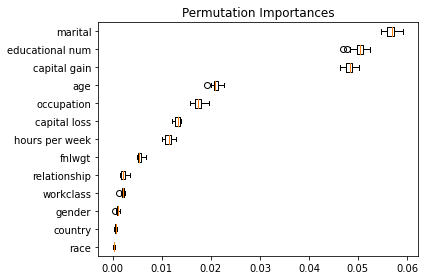

In [13]:
from sklearn.inspection import permutation_importance
result = permutation_importance(pipe, X_train, y_train,
        n_repeats=30,                                           #30 repeats
        random_state=0)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

## Now train a decision tree and visualize the fist splits

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
/home/claudio/Documents/DAS/Advanced_ML/Project/pyenv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


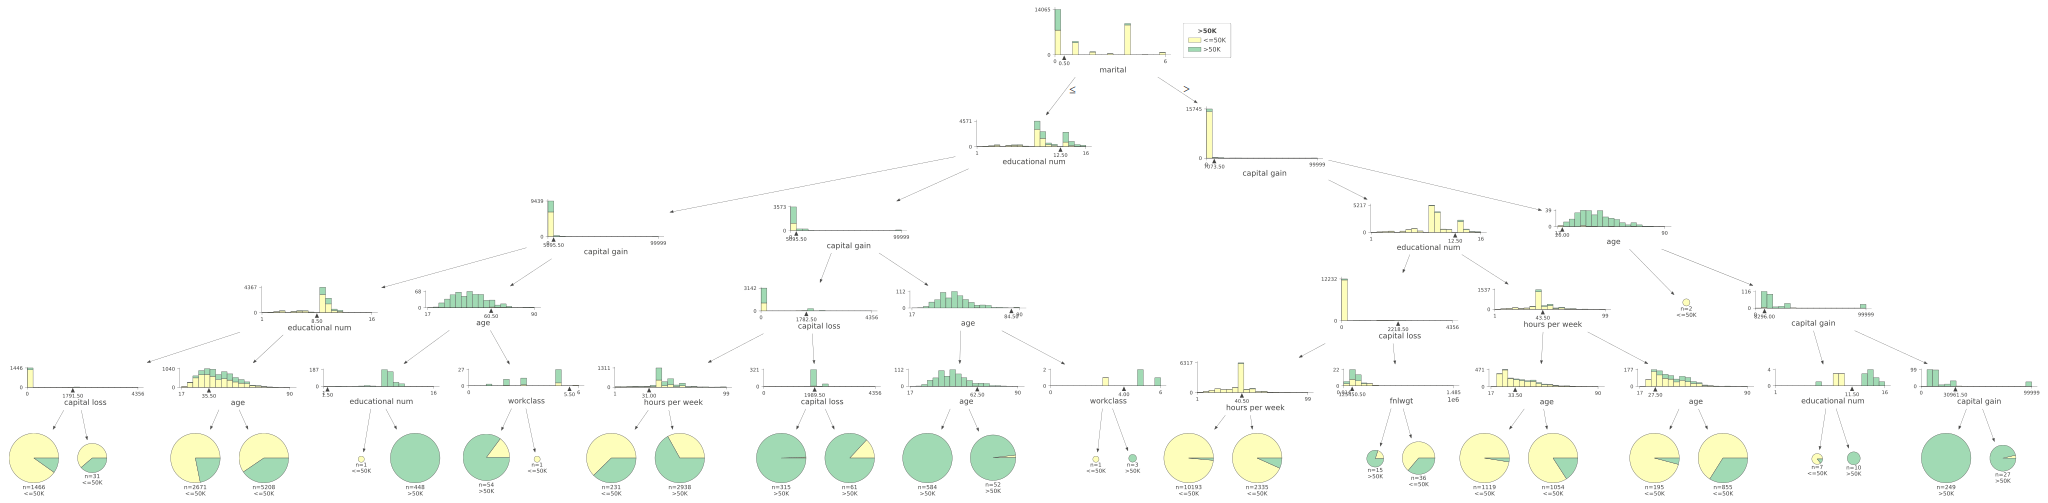

In [4]:
import dtreeviz
from sklearn import tree
from dtreeviz.trees import *

classifier = tree.DecisionTreeClassifier(max_depth=5)  # limit depth of tree
classifier.fit(X_train, y_train)

viz = dtreeviz(classifier, 
               X_train, 
               y_train,
               target_name='>50K',
               feature_names=X_train.columns, 
               class_names=['<=50K', '>50K']  # need class_names for classifier
              )  
              
viz.view()
viz

Click [here](VisualizedTree.svg) if you don't see the figure!

## How do we know a good threshold for bad variables
### => lets create some random features

In [5]:
#Create Set with random variables
X_train_with_random_vars = X_train.copy()
X_train_with_random_vars['my_unique_rand_var'] = np.random.choice(np.arange(X_train.shape[0]), X_train.shape[0], replace=False)
X_train_with_random_vars['my_unique_rand_var_sorted'] = np.arange(X_train.shape[0])

X_test_with_random_vars = X_test.copy()
X_test_with_random_vars['my_unique_rand_var'] = np.random.choice(np.arange(X_test.shape[0]), X_test.shape[0], replace=False)
X_test_with_random_vars['my_unique_rand_var_sorted'] = np.arange(X_test.shape[0])

In [6]:
#Define model
model = RandomForestClassifier(n_estimators=150, max_features=7, max_depth=12, min_samples_leaf=6)
#Compose pipeline
pipe_random = make_pipeline(
        (model)
)
#Apply pipeline on data
pipe_random.fit(X_train_with_random_vars, y_train)
y_test_predicted_with_random_vars = pipe_random.predict(X_test_with_random_vars)
y_train_predicted_with_random_vars = pipe_random.predict(X_train_with_random_vars)

#Calculate scores
skf = StratifiedKFold(n_splits=5, random_state=0,  shuffle=True)
print("Cross val train f1:", cross_val_score(pipe_random, X_train_with_random_vars, y_train, cv=skf, scoring='f1').mean())
print("Overall train f1: ", get_scorer('f1')._score_func(y_train, y_train_predicted_with_random_vars))
print("Overall test f1: ", get_scorer('f1')._score_func(y_test, y_test_predicted_with_random_vars))

Cross val train f1: 0.6778891508279566
Overall train f1:  0.7151377878444697
Overall test f1:  0.6750115901715346


Yes, there is a slight overfitting on the train set

## Calcuate the feature importance including the randomn variables

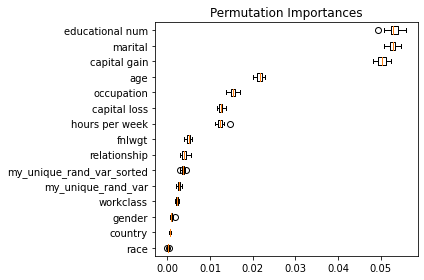

In [7]:
from sklearn.inspection import permutation_importance
result = permutation_importance(pipe_random, X_train_with_random_vars, y_train,
        n_repeats=30,                                           #30 repeats
        random_state=0)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train_with_random_vars.columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

We might assume that the features below the random variables do not contain much relevant information.
- fnlwgt
- relationship
- workclass
- gender
- country
- race 